# Applying Fuzz Testing Techniques to Network-Level Auditing of Consumer IoT

In [13]:
from FlowAnalysis import NetAuditor, PolicyEvaluator
from FlowAnalysis.test import InputFuzzer
from matplotlib import pyplot as plt
from scapy.all import *
import json

figsize = (10, 10)
plt.rcParams.update({'font.size': 18})

First, a look at a policy defined for the handshake operation of the IDevices smart dimmer switch:

In [14]:
with open('./data/policies/Handshake.json') as f:
    handshake_policy = json.load(f)

In [15]:
handshake_policy

{'description': 'Handshake operation',
 'devices': ['192.168.42.67'],
 'flow': {'endpoints': ['192.168.42.0/24']},
 'interaction': {'max_duration': 2000,
  'max_total_payload_bytes': 4200,
  'device': {'max_single_payload_bytes': 1440, 'total_sent_bytes': 3000},
  'endpoint': {'max_single_payload_bytes': 136, 'total_sent_bytes': 1100}}}

Now to perform auditing on a valid capture and output the results:

In [29]:
pdp = PolicyEvaluator([handshake_policy])
audit = NetAuditor(pdp, './data/captures/OnlyHandShakes.json')

In [30]:
audit.flow_analyzer.get_tcp_flows()

[<Flow (192.168.42.62:53138 <--> 192.168.42.67:50008) of 68 packets>,
 <Flow (192.168.42.62:53152 <--> 192.168.42.67:50008) of 73 packets>,
 <Flow (192.168.42.62:53164 <--> 192.168.42.67:50008) of 75 packets>,
 <Flow (192.168.42.62:53172 <--> 192.168.42.67:50008) of 72 packets>,
 <Flow (192.168.42.62:53179 <--> 192.168.42.67:50008) of 73 packets>]

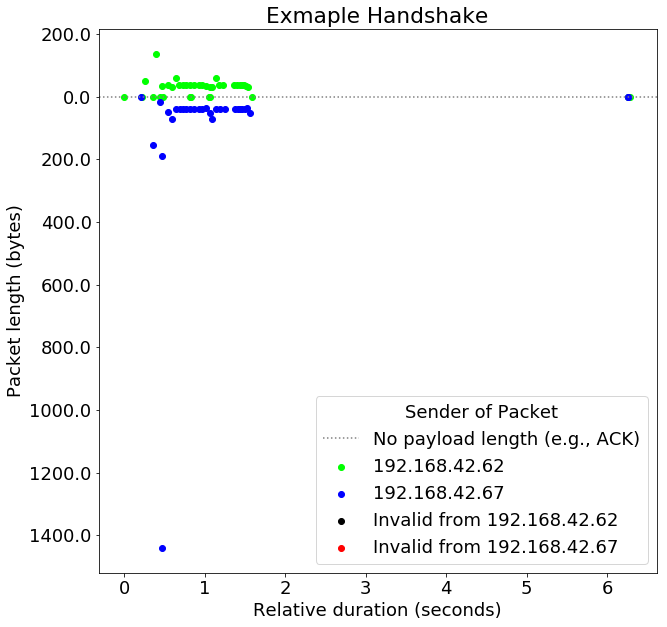

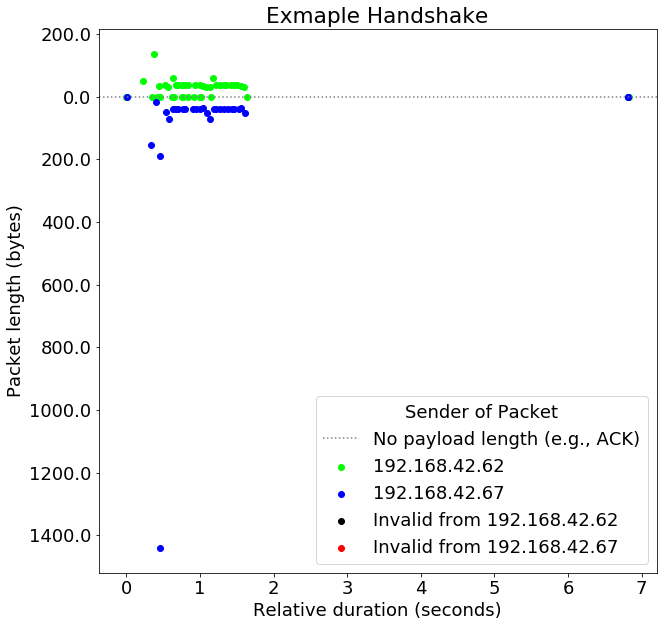

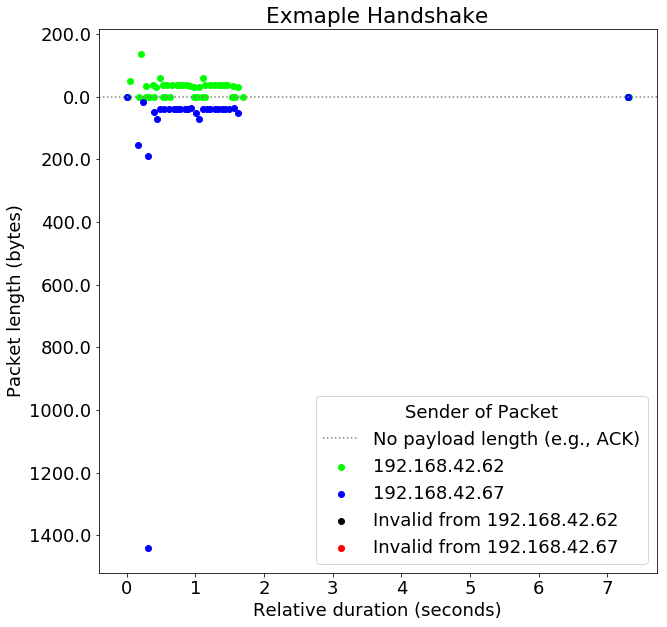

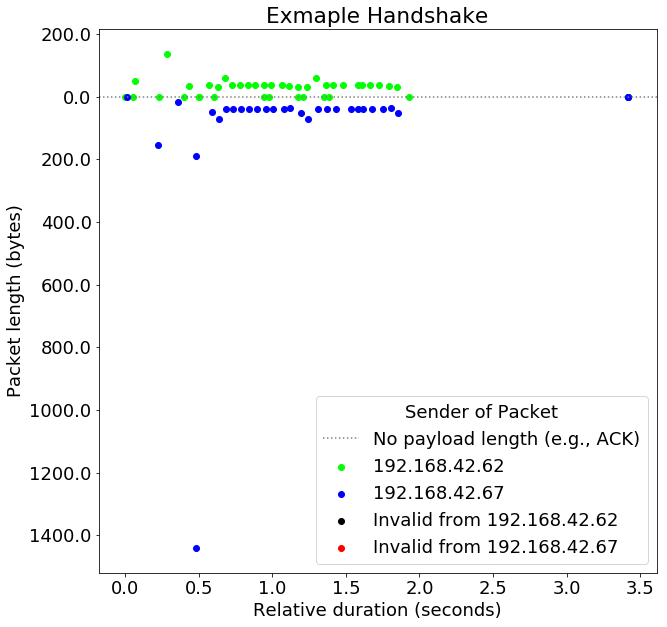

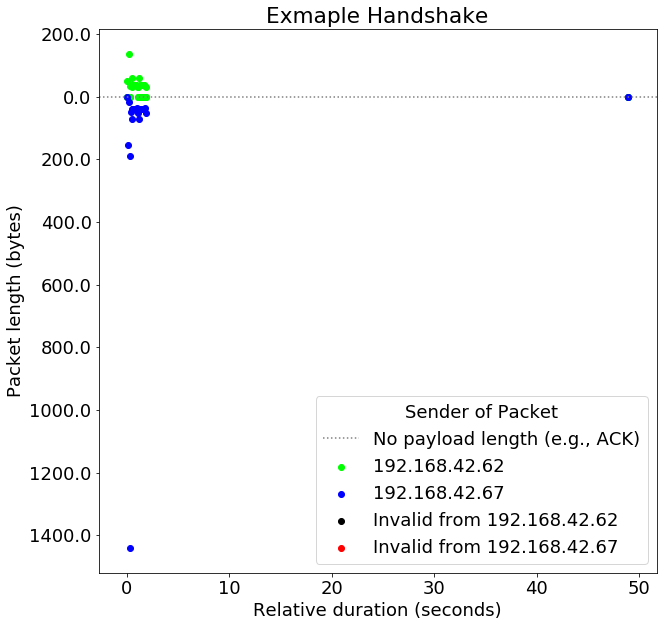

In [31]:
for flow in audit.flow_analyzer.get_tcp_flows():
    fig = plt.figure(figsize=figsize)
    ax = flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)
    ax.set_title('Exmaple Handshake')
    plt.show()

Now for a capture that does not conform to that policy:

In [38]:
audit = NetAuditor(pdp, './data/captures/DimSlider.json')

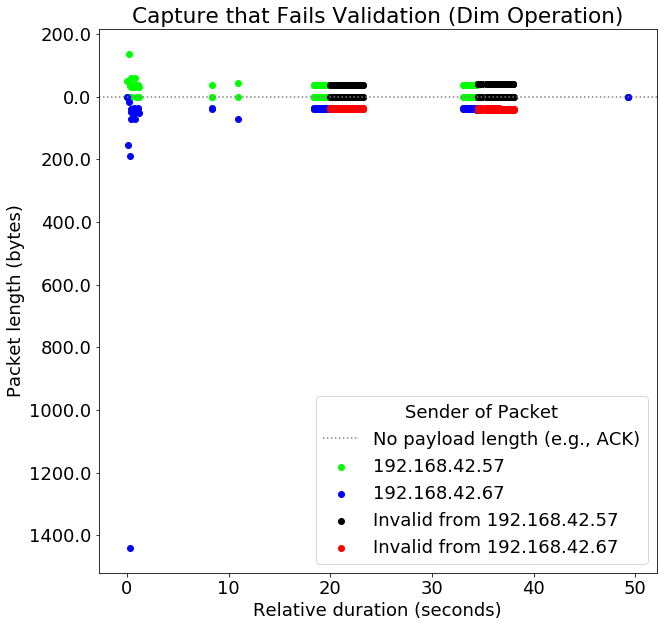

In [39]:
for flow in audit.flow_analyzer.get_tcp_flows():
    fig = plt.figure(figsize=figsize)
    ax = flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)
    ax.set_title('Capture that Fails Validation (Dim Operation)')
    plt.show()

Example of use of fuzz testing:

In [84]:
fuzzer = InputFuzzer('../captures/switches/IDevicesDimmer/Handshakes/OnlyHandShakes.pcapng', handshake_policy)

In [85]:
fuzzed_packets = fuzzer.fuzz()
fuzzed_packets

Time constraint invalidated


<PacketList: TCP:529 UDP:0 ICMP:0 Other:0>

In [86]:
wrpcap('./fuzzed_packets.pcap', fuzzed_packets)
!tshark -r ./fuzzed_packets.pcap -T json > ./fuzzed_packets.json

Now we can audit the resulting packets:

In [94]:
audit = NetAuditor(pdp, './fuzzed_packets.json')

In [95]:
flows = audit.flow_analyzer.get_tcp_flows()
flows

[<Flow (192.168.42.67:50008 <--> 192.168.42.57:53138) of 449 packets>,
 <Flow (192.168.42.57:53172 <--> 192.168.42.67:50008) of 10 packets>,
 <Flow (192.168.42.57:53164 <--> 192.168.42.67:50008) of 21 packets>,
 <Flow (192.168.42.67:50008 <--> 192.168.42.57:53179) of 18 packets>,
 <Flow (192.168.42.57:53152 <--> 192.168.42.67:50008) of 22 packets>,
 <Flow (94.251.161.29:53138 <--> 192.168.42.67:50008) of 1 packets>,
 <Flow (192.168.42.57:53138 <--> 41.36.31.177:50008) of 1 packets>,
 <Flow (119.199.207.17:53179 <--> 192.168.42.67:50008) of 1 packets>,
 <Flow (189.27.133.44:53172 <--> 192.168.42.67:50008) of 1 packets>,
 <Flow (13.205.38.99:53138 <--> 192.168.42.67:50008) of 1 packets>,
 <Flow (192.168.42.67:50008 <--> 166.73.204.73:53164) of 1 packets>,
 <Flow (245.30.182.60:53172 <--> 192.168.42.67:50008) of 1 packets>,
 <Flow (192.168.42.57:53179 <--> 139.114.166.53:50008) of 1 packets>,
 <Flow (189.36.205.111:53172 <--> 192.168.42.67:50008) of 1 packets>]

'\nfor flow in audit.flow_analyzer.get_tcp_flows():\n    fig = plt.figure(figsize=figsize)\n    flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)\n'

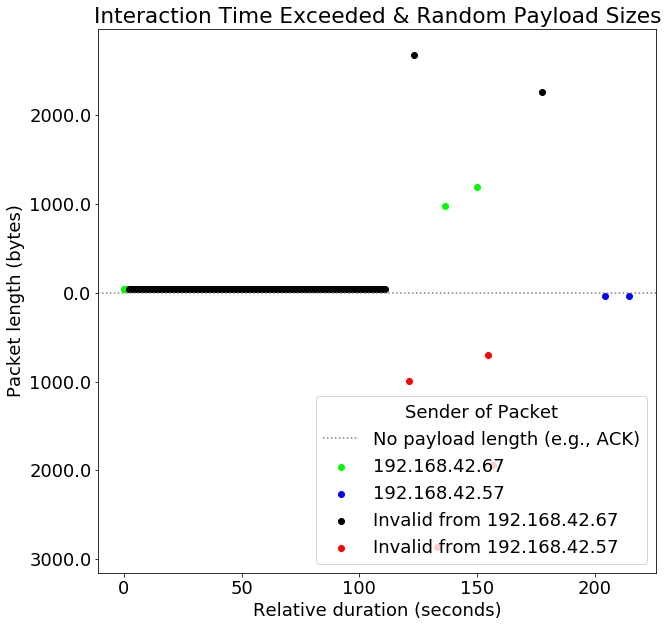

In [96]:
fig = plt.figure(figsize=figsize)
ax = flows[0].get_packets_graph(draw_highlights=False, highlight_invalid=True)
ax.set_title('Interaction Time Exceeded & Random Payload Sizes')
"""
for flow in audit.flow_analyzer.get_tcp_flows():
    fig = plt.figure(figsize=figsize)
    flow.get_packets_graph(draw_highlights=False, highlight_invalid=True)
"""

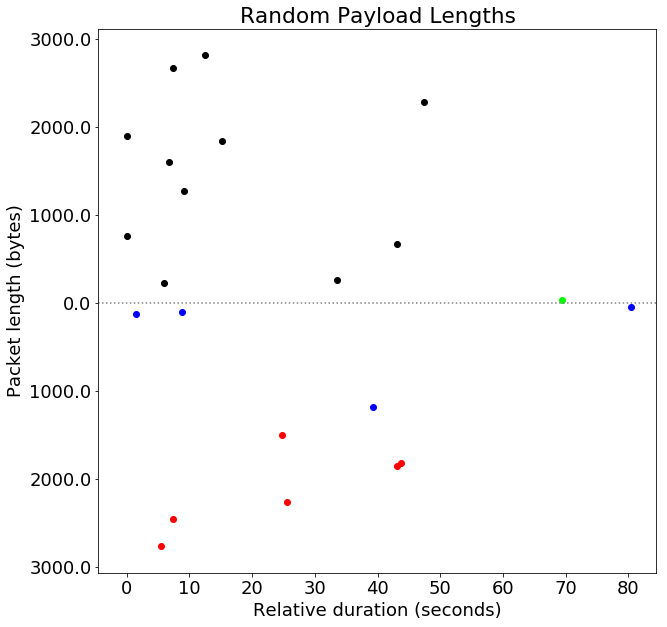

In [103]:
fig = plt.figure(figsize=figsize)
ax = flows[4].get_packets_graph(draw_highlights=False, highlight_invalid=True)
ax.set_title('Random Payload Lengths')
ax.legend().remove()
plt.show()

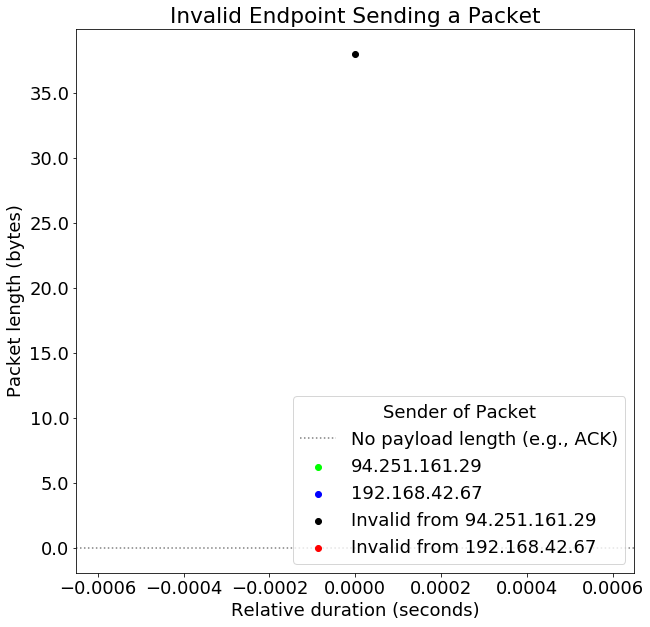

In [101]:
fig = plt.figure(figsize=figsize)
ax = flows[5].get_packets_graph(draw_highlights=False, highlight_invalid=True)
ax.set_title('Invalid Endpoint Sending a Packet')
# ax.legend().remove()
plt.show()